# <strong>Importing Packages</strong>
***********

In [300]:
import pandas as pd
import glob
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline


from bs4 import BeautifulSoup
import re

from gensim.models.word2vec import Word2Vec
from gensim import models

from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import time


import nltk
from nltk.corpus import stopwords
stopwordsList=stopwords.words('english')

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.optimizers import Adam

import time
from keras import metrics

# Reading the file

*******************

    
        

 <i>Fetching the Document Id and the description from all the json file.</i>
    

In [301]:
id_list=[]
description_list=[]

#Fetching the Records
for directory_path in glob.glob('docs/*.json'):
    with open(directory_path) as f:
        data = json.load(f)
    id_list.append(os.path.basename(directory_path).split('.')[0])
    description_list.append(data['jd_information']['description'])

df_description=pd.DataFrame()

df_description['description']=description_list

#DOCUMENT ID saved as string converting it to integer
df_description['Document ID']=list(map(int, id_list))
df_description.head()

,description,Document ID
0,Urgent positions for Travel Executive at Saane...,5922081
1,"Dear Candidate,Greetings From Continental Immi...",6523883
2,We Have urgent poitions for Ticketing Executiv...,6600981
3,We Have Urgent positions for Travel booking cu...,6686185
4,Experience in Travel Industry.We have urgent o...,6726409


********************************
<i>Fetching the Document ID and Department from the csv file</i>

In [302]:
df_label=pd.read_csv('document_departments.csv')
df_label.head()

,Document ID,Department
0,8196431,Customer service
1,8278123,Digital Marketing
2,8331625,Sales
3,8331003,Back office ticketing
4,8277939,Digital Marketing


*************************************************
<i> Joining the two Table taking Document ID as key.</i>

In [303]:
df=pd.merge(df_description,df_label,on='Document ID',how='outer')
df.head()

,description,Document ID,Department
0,Urgent positions for Travel Executive at Saane...,5922081,Customer service
1,"Dear Candidate,Greetings From Continental Immi...",6523883,Sales
2,We Have urgent poitions for Ticketing Executiv...,6600981,Ticketing
3,We Have Urgent positions for Travel booking cu...,6686185,Customer service
4,Experience in Travel Industry.We have urgent o...,6726409,Ticketing


# Data Exploration
********

    -Checking for null columns.
    -Checking for column with empty strings.
    -Stripping white spaces at beginning and end from the label names.
    -Distribution of various categories.

In [304]:
print("Total number of records is {}".format(df.shape[0]))

Total number of records is 1162


****
<i>-No column has null values</i>

In [305]:
#No column has null values
df.isnull().any()

description    False
Document ID    False
Department     False
dtype: bool

**********
<i>-Out of 1162 records only 745 records are not empty strings.</i>

In [306]:
df=df.loc[df['description']!='']
print("Total records after removing the empty strings is {}".format(df.shape[0]))

Total records after removing the empty strings is 745


*****
<i>-Remove spaces.<br>
-Distribution of the label.</i>

In [307]:
df['Department']=df['Department'].apply(lambda x: x.strip())
df['Department'].value_counts()

Ticketing                          230
Sales                              148
Digital Marketing                  132
Customer service                    49
Marketing                           30
Finance                             26
Operations                          25
Back office ticketing               16
Administration                      15
IT                                  13
Presales                            10
Technology                          10
Maintenance                          8
Recruitment                          5
Public Relations                     5
Engineering Design Construction      4
Logistics                            3
Marine Engineering                   3
Content                              2
Data entry                           2
Marine Deck                          2
Analytics                            2
Procurement                          1
Flight Operations                    1
Marine Service Steward               1
Learning and Development 

********
<strong>Distribution Analysis</strong>

    - Category with very less data points will be considered as noise by model so removing the categories 
    Logistics,Marine Engineering,Content,Marine Deck,Analytics,Data entry,Learning and Development,Airline Ground Operations,Marine Service Steward,Procurement,Flight Operations as these are having less than 4 records 

In [308]:
less_data_point_column=['Logistics','Marine Engineering','Content','Marine Deck','Data entry','Analytics','Procurement','Flight Operations','Marine Service Steward','Airline Ground Operations','Learning and Development']
df=df.loc[~df['Department'].isin(less_data_point_column)]

# DATA PREPROCESSING
***********

    -Helper function
    -Data preprocessing using these functions
    -Distribution of Length of text documents for a optimal selection of max length while building a model.

**************
<i>- Helper Function for data processing</i>

In [309]:
#Removing the HTML TAGS
def htmltagRemoval(x):
    return BeautifulSoup(x, 'lxml').get_text()

def remove_mention(x):
    return re.sub(r'@[A-Za-z0-9]+','',x)

#Removing the urls
def remove_urls(x):
    return re.sub('https?://[A-Za-z0-9./]+','',x)

#Removing the Numbers
def remove_hastagNumbers(x):
    return re.sub("[^a-zA-Z]", " ", x)

#Split text at CamelCase
def split_uppercase(x):
    return str(" ".join([" ".join(re.split("([A-Z]{1}[a-z]+)",word)) for word in x.split(' ')]))
    
#Converting text in lowercase
def LowerCase(x):
    return str(x.lower())

#Removing stopwords
def StopwordsRemoval(x):
    return str(' '.join([each if each not in stopwordsList else '' for each in x.split(' ')]))

#def remove_single_character_words(x):
#    return str(' '.join([each if len(each)>1 else '' for each in x.split()]))

#Removing multiple white spaces from the text
def RemoveMultipleWhiteSpaces(x):
    FILTER_MULTIPLE_WHITESPACES = "\s\s+"
    return re.sub(FILTER_MULTIPLE_WHITESPACES,' ',x)

# strip spaces at the end and the starting
def toStripWhiteSpaces(x):
    return x.strip()

#Function for calling all the other functions
def preprocess(x):
    return toStripWhiteSpaces(RemoveMultipleWhiteSpaces(StopwordsRemoval(LowerCase(split_uppercase(remove_hastagNumbers(remove_urls(remove_mention(htmltagRemoval(x)))))))))


******
<i>    - Processing text for helper functions</i>

In [310]:
#Preprocessing the text by using helper functions
df['preprocessed_description']=df['description'].apply(preprocess)

******

<i>    - Distribution of Length of document Calculation</i>

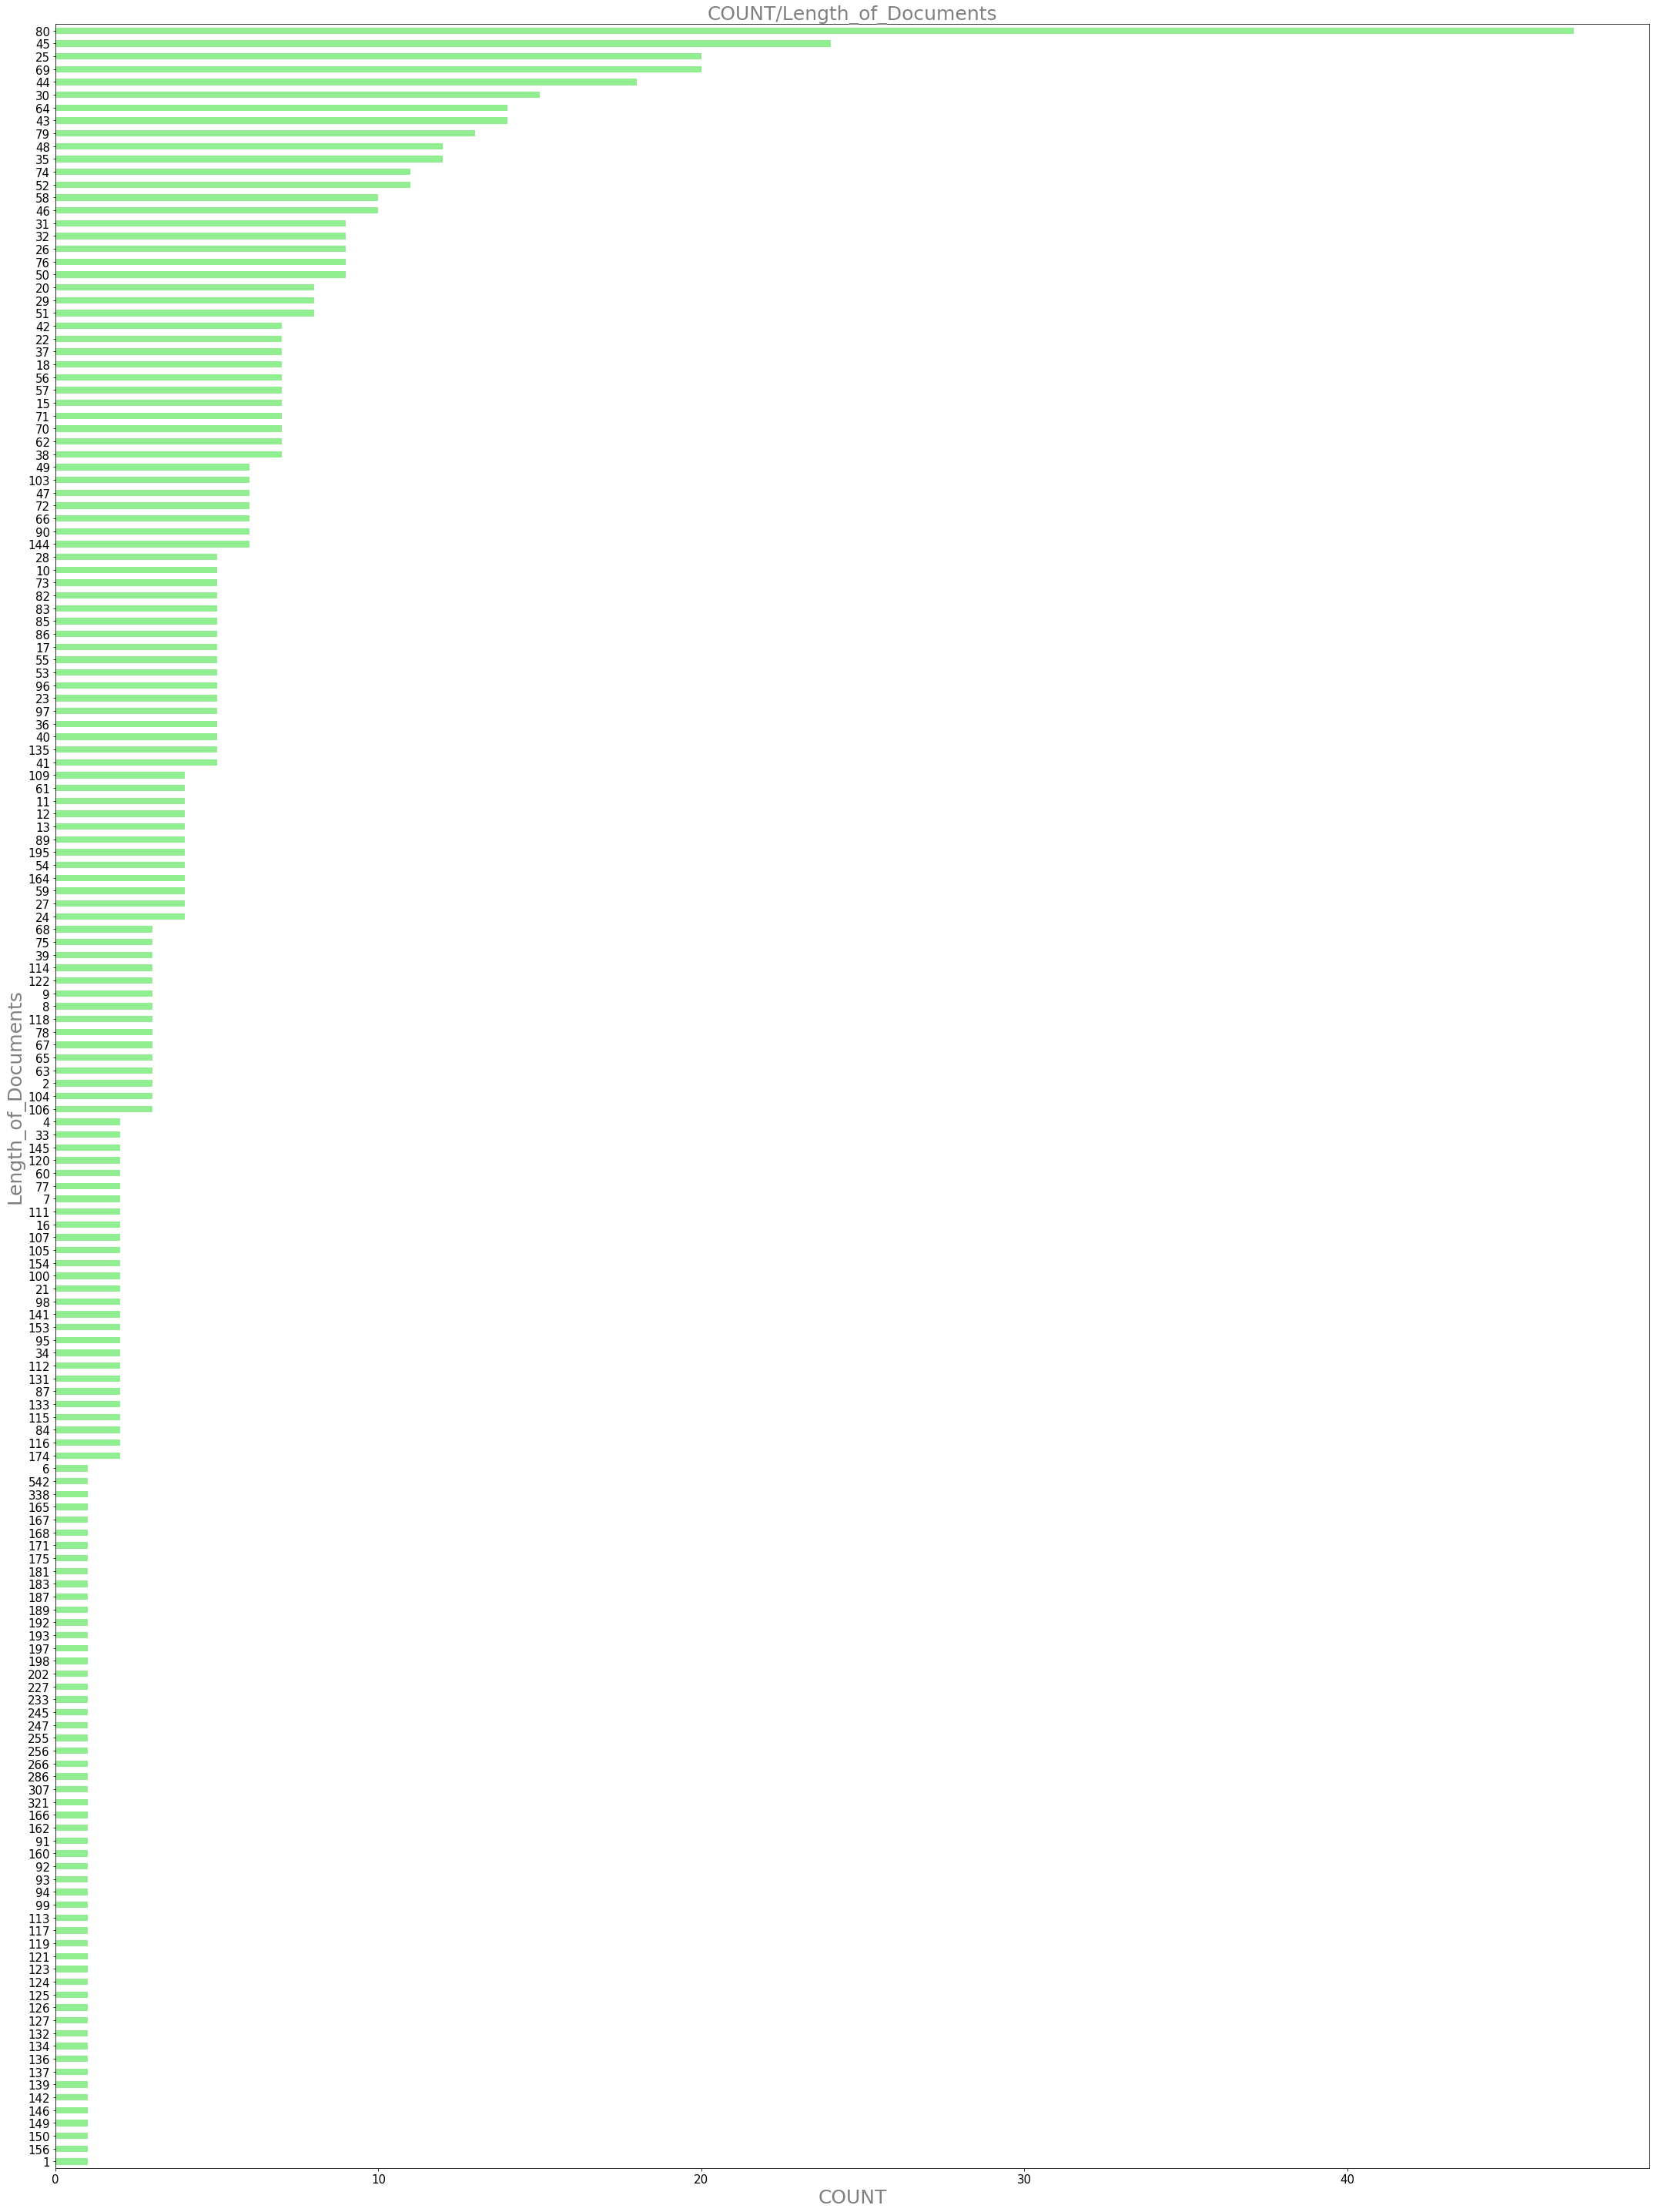

In [311]:
#Length of documents
df['Length_of_Documents']=df['preprocessed_description'].apply(lambda x: len(x.split(' ')))
df.sort_values('Length_of_Documents',inplace=True,ascending=True)

column_name='Length_of_Documents'
fig,ax=plt.subplots(1,1,figsize=(30,40))

#To change color of bar use m-magenta,c-cyan,r-red,g-green,b-blue
df[column_name].value_counts().plot(kind='barh',ax=ax,title='Count/'+column_name,fontsize=15,color='LightGreen')

title='COUNT/'+column_name
ax.set_title(title,fontsize= 25,color='Gray')
plt.gca().invert_yaxis()
plt.xlabel('COUNT',fontsize=25,color='Gray')
plt.ylabel(column_name,fontsize=25,color='Gray')

fig.tight_layout()

****************
# Data Splitting

    -Splitting the data in train test sample.
    -Using stratified sampling to check the accuracy for each Department label.
    

In [312]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(df['preprocessed_description'].values,df['Department'].values,test_size=0.2,random_state=0,stratify=df['Department'].values)

***********************
# Different Model building approches

    -Using a tokenized embedding layer folowed by a cnn model.
    -Using a word embedding layer followed by a cnn model.
    -Using a term frequency/inverse document frequency then training a SVM model

***************
## Tokenizer Embedding followed by a cnn model

*************
<strong>Feature Engineering</strong>

    - Converting text into features using tokenizer.
    - Converting the Department labels into one hot encoding.

In [313]:
#####################################Features#############################################
#Create a tokenizer Object
tok = Tokenizer()

#Initialize the tokenizer with training data
tok.fit_on_texts(Xtrain)

#Getting all the values
texts=df['preprocessed_description'].values

#Transform the entire data
cnn_texts_seq = tok.texts_to_sequences(texts)

#Maximum length of a sequence
maxlen=100 

#Padding the sequence for having same length
cnn_texts_padded = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)


###################################Target###################################################

#Create a labelencoder 
le = LabelEncoder()

#Initialize the labelencoder by training data
le.fit(ytrain)

#Getting all the values 
tags=df['Department'].values

#Transform the entire data
tags = le.transform(tags)

#Converting the Label to one hot encoding
ytrain_onehot = to_categorical(tags)

In [314]:
#The vocabulary size of the text
vocab_size=len(tok.word_index)+1

***********
<strong>Model Arhitecture</strong>

In [315]:
#Setting seed to control randomness
np.random.seed(10)
batch_size=16
# added filter
model = Sequential()
model.add(Embedding(vocab_size,batch_size,input_length=max_len))
model.add(Dropout(0.2))

model.add(Conv1D(32, 2,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(32))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))
model.summary()
optimizer=Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(cnn_texts_padded,ytrain_onehot,batch_size=batch_size,epochs=20,verbose=1,validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 16)           64768     
_________________________________________________________________
dropout_60 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 100, 32)           1056      
_________________________________________________________________
global_max_pooling1d_32 (Glo (None, 32)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_61 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)                528       
Total para

************************
<strong>Plotting the results from model training</strong>

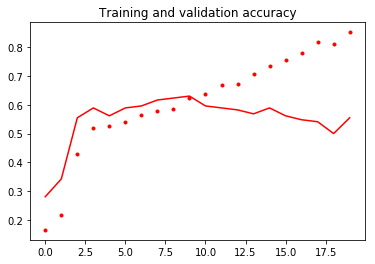

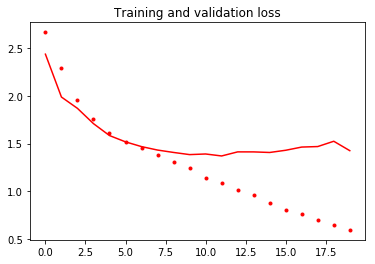

In [316]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    
    
plot_training(history)

<strong><i>The best accuracy of this model is 63.01 on validation set at epoch 10.<br>
As the data points are very less the model will easily overfit.<br>
This could be resolved by adding more data.</i></strong>

 ***********************
## Word Embedding layer followed by cnn model

*************
<strong>Feature Engineering</strong>
    
    - Training the Word2Vec model.
    - Converting text into features using Word2Vec model
    - Converting the Department labels into one hot encoding.

In [317]:
#Creating token list for each sentence
word_list_in_sentences=[]
for sentence in Xtrain:
    word_list_in_sentences.append(sentence.split())

In [318]:
#Embedding Dimension 
embedding_dimension=100

#Creating a word embedding model with the specified embedding
word_embedding_model = Word2Vec(sentences=word_list_in_sentences, size=embedding_dimension, window=3, min_count=2, workers=4, sg=0)

#Saving the word2vec model
word_embedding_model.wv.save_word2vec_format('model/wordvectors.bin')


In [319]:
#Similar words
word_embedding_model.wv.most_similar("skills")

[('excellent', 0.9997909665107727),
 ('good', 0.9997710585594177),
 ('english', 0.9997198581695557),
 ('must', 0.9996811151504517),
 ('knowledge', 0.9996708035469055),
 ('communication', 0.9996092319488525),
 ('written', 0.9996014833450317),
 ('profile', 0.9995790719985962),
 ('candidate', 0.9995235204696655),
 ('apply', 0.9995076060295105)]

**************
  <i>  - Helper function for converting text into vectors </i>

In [320]:
def get_text_vector(w2vmodel,sentence):
    list_of_vectors=[]
    for w in sentence.split(' '):
        if w in w2vmodel.wv.vocab.keys():
            list_of_vectors.append(w2vmodel[w])
        else:
            list_of_vectors.append(np.zeros(w2vmodel.vector_size))
    return list_of_vectors

def mean(a):
    return np.mean(a, axis=0)

def embedding_vector(w2vmodel,sentence):
    return mean(get_text_vector(w2vmodel,sentence))

In [321]:
#####################################Features#############################################

#Loading the word2vec model
w2vmodel =models.KeyedVectors.load_word2vec_format('model/wordvectors.bin',binary=False)

#Vocabulary size
vocab_size_w2v=len(w2vmodel.wv.vocab)


#Getting all the values
text_w2v=df['preprocessed_description'].values

features=[]

#Fetching features from the word2vec model for each text
for each in text_w2v:
    features.append(list(embedding_vector(w2vmodel,each)))

#Features numpy matrix  
features=np.array(features)
    
###################################Target###################################################

#Create a labelencoder 
le_wv = LabelEncoder()

#Initialize the labelencoder by training data
le_wv.fit(ytrain)

#Getting all the values 
tags_w2v=df['Department'].values

#Transform the entire data
label = le.transform(tags_w2v)

#Converting the Label to one hot encoding
ytrain_onehot_w2v = to_categorical(label)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


***********
<strong>Model Arhitecture</strong>

In [322]:
np.random.seed(10)

# added filter
model = Sequential()
model.add(Embedding(vocab_size_w2v,16,input_length=embedding_dimension))
model.add(Dropout(0.2))
model.add(Conv1D(32, 2,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(32))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))
model.summary()
optimizer=Adam(lr=0.0001)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(features,ytrain_onehot_w2v,batch_size=32,epochs=10,verbose=1,validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 100, 16)           40032     
_________________________________________________________________
dropout_62 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 100, 32)           1056      
_________________________________________________________________
global_max_pooling1d_33 (Glo (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 16)                528       
Total para

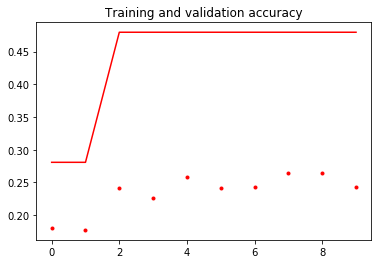

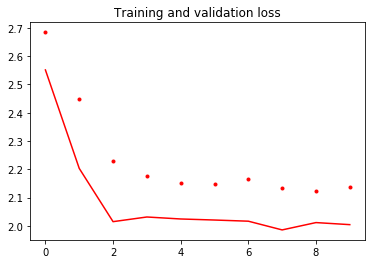

In [323]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    
    
plot_training(history)



<strong><i>The model accuracy is 47.95%.<br>
The model accuracy is going constant because the word embeddings is not a good feature conversion matrix for very less data.
<br>
This could be resolved by adding more data and then training word embeddings on top of that.</i></strong>

 ***********************
## Creating term frequency-inverse document frequency and building a svm model

*************
<strong>Feature Engineering</strong>
    
    - Tranforming the data into features using tf-idf.
    - Tranforming the labels into numbers using labelencoder.
    - Building a SVM model

In [324]:
########################################################################################################
#########################################Train Data#####################################################
########################################################################################################




###########################################Features#####################################################

#Creating a object of tf-idf vectorizer
vec = TfidfVectorizer()

#Initializing the vectorizer on train data
X = vec.fit_transform(Xtrain)

#Saving the matrix in a dataframe
df_tf_idf = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


############################################Labels########################################################

#Creating a object of label encoder
le = preprocessing.LabelEncoder()

#Initializing the encoder on train data 
y_train_label_encoded=le.fit_transform(ytrain)


########################################################################################################
#########################################Test Data######################################################
########################################################################################################


###########################################Features#####################################################

#Transform the test data 
X = vec.transform(Xtest)

#Saving the matrix in a dataframe
df_tf_idf_test = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


############################################Labels#######################################################

#Encoding the test set
y_test_label_encoded=le.fit_transform(ytest)

***********************
<strong>Model Training</strong>

In [325]:
from sklearn.svm import LinearSVC

#Creating a SVM object with a random state for reproducible results
clf = LinearSVC(random_state=0,C=1)

#Training the model on train data
clf.fit(df_tf_idf,y_train_label_encoded)



LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

*************************
<strong>Evaluating the model</strong>

In [326]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score

y_predicted_test=clf.predict(df_tf_idf_test)
cm=confusion_matrix(y_test_label_encoded,y_predicted_test)
accuracy=accuracy_score(y_test_label_encoded,y_predicted_test)
print("Accuracy of the model is {}".format(accuracy))



Accuracy of the model is 0.7465753424657534


In [327]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_label_encoded, y_predicted_test, target_names=le.classes_))


                                 precision    recall  f1-score   support

                 Administration       0.00      0.00      0.00         3
          Back office ticketing       0.50      0.67      0.57         3
               Customer service       1.00      0.30      0.46        10
              Digital Marketing       0.96      0.96      0.96        26
Engineering Design Construction       0.00      0.00      0.00         1
                        Finance       1.00      0.40      0.57         5
                             IT       1.00      0.67      0.80         3
                    Maintenance       1.00      0.50      0.67         2
                      Marketing       1.00      0.33      0.50         6
                     Operations       0.50      0.40      0.44         5
                       Presales       0.00      0.00      0.00         2
               Public Relations       0.00      0.00      0.00         1
                    Recruitment       1.00      1.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<strong><i>The model accuracy is 74.65% on validation set.<br>
As the data points are very less the model will easily overfit.<br>
This could be resolved by adding more data.</i></strong>

***********************
************************
# CONCLUSION

## <strong>The three model approaches</strong>
    
  <i><u>Tokenizer with cnn<u></i><br>

<strong>Pros</strong><br>
- The model is giving a accuracy of <strong>63.01%</strong> which can be further improved by fine tuning the model.
- The tokenized representation is performing better for less data points.<br>

<strong>Cons</strong><br> 
- In case of increasing the data the model will not perform very good.
- The optimum sequence length will be majorly affecting the accuracy of the model.
                    
<i><u>Word Embedding with cnn<u></i><br>


<strong>Pros</strong><br>
- The model is highly scalable although it is giving a accuracy of just <strong>47.95%</strong> but with increase in data word embedding will outperform other tokenizer based approches. <br>

<strong>Cons</strong><br> 
- The word embedding representation can not handle out of vocabulary(OOV) word problem hence the words which are not in training data but present in test data cannot be taken.

<i><u>TF-IDF with SVM model<u></i><br>


<strong>Pros</strong><br>
- As the data is less this model will outperform all the other models providing a accuracy of <strong>74.65%</strong> . <br>
- SVM is computationally expensive but some variation of SVM are highly efficient in sense of time complexity and the accuracy even when the data is more.

<strong>Cons</strong><br> 
- The tf-idf will not suite with large amout of data and memory issues will come because of the large matrix size..




*****************
## Challenges in working with this data.

- The regular expression approach for replacing specific keywords may not work as the data will increase,the cleaning will take more time and regex is not that much scalable.Even for 1 million records it will take days to process it and if it fails we cannot track it properly.
- Identifying the name of the person in the mail as in future that person may not be available or there are persons with same name in two departments.
- Identifying the system generated templates and messages or signature.
- Handling the typos that is human errors.
- Handling words with length less than 3 e.g. it,hr [for this usecase these are important words] and cannot be replaced directly.
- Word embedding may not be best for representation as the out of vocabulary problem will still be there.
- We have to consider the time of model response also.If it is taking too much time it may create a lag in user interface and thus providing less profit.
- If we are looking for top 3-5 suggestions we have go with some probability based classifiers 


*****************
## Future Works

- For handling replacement of words we have to consider some other data structures based approach which will be highly efficient.
- Trying out some more low level embedding like character we can solve the problem of out of vocabulary word.
- Using a content specific auto correction may help in removing typos.
- Building a list of stopwords like [dear,regards,thank you,must,should] these are use case specific stopwords and need to be taken care of.
- Having a curated list of business specific words will help in tokenizing the text and creating ngrams for those words.
- Collecting the list of all the agent or by using dictionary based approach the problem of name detection can be removed.We can try with NER tagging also.
- Model training can be improved by trying other approaches which are build majorly for text classification and response is fast with a probability of each class label. 

